### Simple file to explore the mcPhases data

In [ ]:
# First, let's get some summary statistics
# 1. Load the data
# 2. Use pandas to get summary statistics
# 3. Check for missing values


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import json

In [8]:
# Load dataset
glucose_data = pd.read_csv(r"C:\Users\carlo\OneDrive\Documents\Icahn\M1\MD+ Datathon\mcPhases\data\mcphases\1.0.0\glucose.csv")
# Period Data
period_data = pd.read_csv(r"C:\Users\carlo\OneDrive\Documents\Icahn\M1\MD+ Datathon\mcPhases\data\mcphases\1.0.0\hormones_and_selfreport.csv")

# Display heads of dataframes
print("Glucose Data Head:")
print(glucose_data.head(10))
print("\nPeriod Data Head:")
print(period_data.head(10))

Glucose Data Head:
   id  study_interval  is_weekend  day_in_study timestamp  glucose_value
0   1            2022        True             1  00:04:06            4.9
1   1            2022        True             1  00:09:06            5.0
2   1            2022        True             1  00:14:07            5.1
3   1            2022        True             1  00:19:06            5.1
4   1            2022        True             1  00:24:06            5.1
5   1            2022        True             1  00:29:06            5.2
6   1            2022        True             1  00:34:07            5.3
7   1            2022        True             1  00:39:07            5.3
8   1            2022        True             1  00:44:07            5.3
9   1            2022        True             1  00:49:06            4.9

Period Data Head:
   id  study_interval  is_weekend  day_in_study       phase   lh  estrogen  \
0   1            2022        True             1  Follicular  2.9      94.2   
1  

In [11]:
glist = (glucose_data
         .groupby(["id", "study_interval", "day_in_study"], as_index=False)
         .agg(glucose_values=("glucose_value", list))
        )

glist["glucose_times"] = (glucose_data
    .groupby(["id", "study_interval", "day_in_study"])["timestamp"]
    .agg(list)
    .values
)

combined = period_data.merge(
    glist,
    on=["id", "study_interval", "day_in_study"],
    how="left"
)


Individual Data Head:
   id  study_interval  is_weekend  day_in_study       phase   lh  estrogen  \
0   1            2022        True             1  Follicular  2.9      94.2   
1   1            2022       False             2  Follicular  1.2     226.3   
2   1            2022       False             3  Follicular  3.5     276.8   
3   1            2022       False             4   Fertility  1.8     322.1   
4   1            2022       False             5   Fertility  4.6     244.9   
5   1            2022       False             6   Fertility  5.0     364.7   
6   1            2022        True             7   Fertility  5.0     364.7   
7   1            2022        True             8   Fertility  5.0     364.7   
8   1            2022       False             9   Fertility  4.6     222.3   
9   1            2022       False            10      Luteal  3.0      63.6   

   pdg flow_volume  flow_color  ...      sorebreasts          fatigue  \
0  NaN  Not at all  Not at all  ...  Very Low

C:\Users\carlo\AppData\Local\Temp\ipykernel_5760\1003887182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_data['avg_glucose'] = individual_data['glucose_values'].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
C:\Users\carlo\AppData\Local\Temp\ipykernel_5760\1003887182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_data['min_glucose'] = individual_data['glucose_values'].apply(lambda x: np.min(x) if isinstance(x, list) and len(x) > 0 else np.nan)

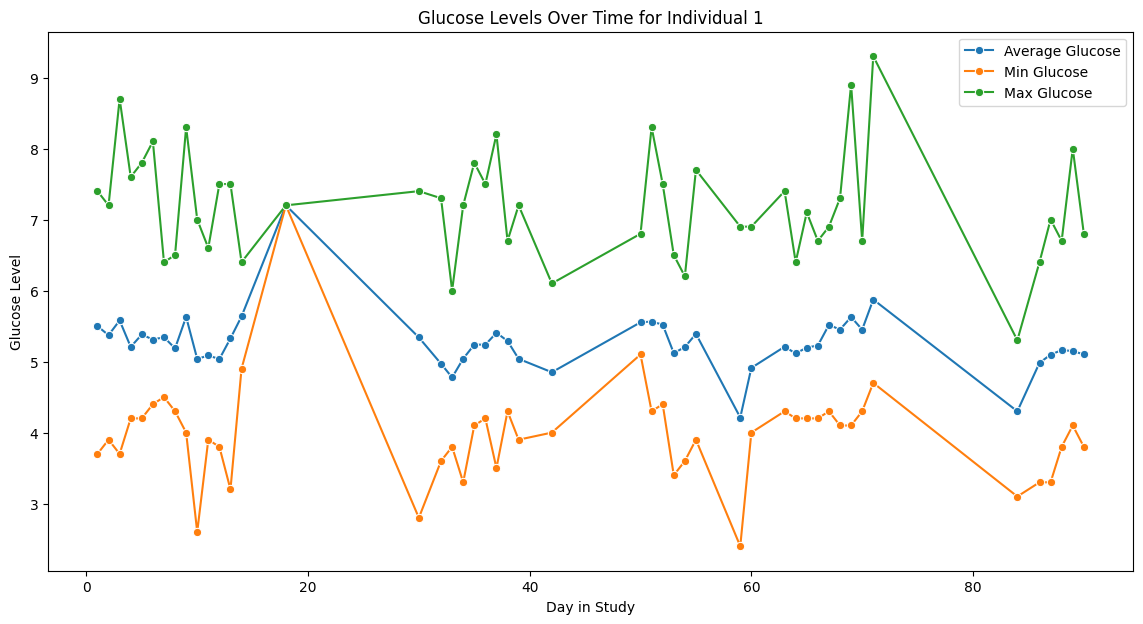

In [17]:
# Now show a simple time-series using this combined data of glucose levels for a single individual color-coded by phase (follicular/luteal/fertility/menstrual)
individual_id = combined['id'].unique()[0]
individual_data = combined[combined['id'] == individual_id]
print("\nIndividual Data Head:")
print(individual_data.head(10))
# First, we will bin glucose by day, setting up an average glucose level per day per individual
# We will also extract the min and max glucose level for each day. 
individual_data['avg_glucose'] = individual_data['glucose_values'].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
individual_data['min_glucose'] = individual_data['glucose_values'].apply(lambda x: np.min(x) if isinstance(x, list) and len(x) > 0 else np.nan)
individual_data['max_glucose'] = individual_data['glucose_values'].apply(lambda x: np.max(x) if isinstance(x, list) and len(x) > 0 else np.nan)

# We will plot three lines using seaborn, one for average, one for min, and one for max glucose levels per day. Each section of the plot will be color-coded by phase.
plt.figure(figsize=(14, 7))
sns.lineplot(data=individual_data, x='day_in_study', y='avg_glucose', label='Average Glucose', marker='o')
sns.lineplot(data=individual_data, x='day_in_study', y='min_glucose', label='Min Glucose', marker='o')
sns.lineplot(data=individual_data, x='day_in_study', y='max_glucose', label='Max Glucose', marker='o')

# Color code by phase by simply highlighting the background of the whole plot according to each phase on that day. For example, if days 1-5 are all follicular, that section should be highlighted the corresponding color.
phase_colors = {
    'menstrual': 'lightpink',
    'follicular': 'lightblue',
    'fertility': 'lightgreen',
    'luteal': 'lightyellow'
}
for phase, color in phase_colors.items():
    phase_days = individual_data[individual_data['phase'] == phase]['day_in_study']
    if not phase_days.empty:
        plt.axvspan(phase_days.min(), phase_days.max(), color=color, alpha=0.3, label=phase.capitalize())
plt.title(f'Glucose Levels Over Time for Individual {individual_id}')
plt.xlabel('Day in Study')
plt.ylabel('Glucose Level')
plt.legend()
plt.show()


grouped Data Head:
   day_in_study                                     glucose_values       phase
0             1  [4.9, 5.0, 5.1, 5.1, 5.1, 5.2, 5.3, 5.3, 5.3, ...  Follicular
1             2  [6.5, 6.7, 6.8, 6.9, 6.9, 6.8, 6.9, 6.9, 6.9, ...  Follicular
2             3  [5.3, 5.3, 5.4, 5.6, 5.7, 5.7, 5.8, 5.8, 5.9, ...  Follicular
3             4  [5.5, 5.5, 5.5, 5.3, 5.2, 5.3, 5.3, 5.2, 5.4, ...  Follicular
4             5  [6.7, 7.0, 7.2, 7.4, 7.5, 7.7, 7.7, 7.7, 7.8, ...  Follicular
5             6  [4.8, 4.9, 4.8, 4.8, 4.9, 5.2, 5.2, 5.1, 5.2, ...  Follicular
6             7  [5.1, 4.9, 5.0, 5.0, 5.1, 5.2, 5.1, 5.1, 5.2, ...  Follicular
7             8  [5.4, 5.4, 5.4, 5.4, 5.4, 5.6, 5.5, 5.4, 5.3, ...   Fertility
8             9  [4.9, 4.9, 5.0, 5.2, 5.2, 5.1, 5.1, 5.2, 5.2, ...   Fertility
9            10  [6.6, 6.5, 6.5, 6.7, 6.7, 6.7, 6.8, 6.7, 6.4, ...   Fertility


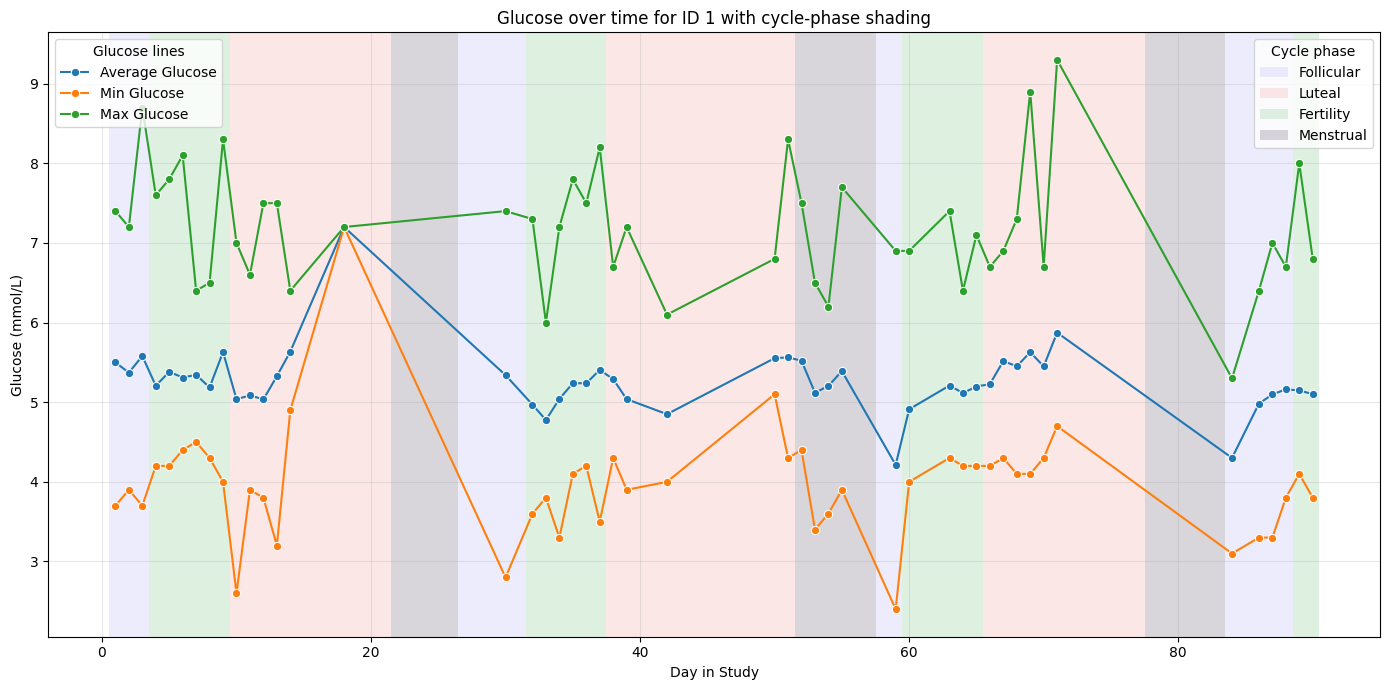

In [24]:
# --- imports (safe if already imported) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# pick one individual and make a copy to avoid chained-assignment warnings
individual_id = combined['id'].iloc[0]
individual_data = combined.loc[combined['id'] == individual_id].copy()

#Instead of picking one individual, average over all individuals
grouped_data = combined.groupby('day_in_study').agg({
    'glucose_values': lambda x: [val for sublist in x.dropna() for val in sublist],
    'phase': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}).reset_index()

print("\ngrouped Data Head:")
print(grouped_data.head(10))

# ensure day is numeric and sorted
if np.issubdtype(individual_data['day_in_study'].dtype, np.datetime64):
    # if it's a datetime, convert to day index relative to the first day
    d0 = individual_data['day_in_study'].min()
    individual_data['day_idx'] = (pd.to_datetime(individual_data['day_in_study']).dt.normalize() - pd.to_datetime(d0).normalize()).dt.days.astype(int) + 1
else:
    individual_data['day_idx'] = pd.to_numeric(individual_data['day_in_study'], errors='coerce').astype('Int64')

individual_data = individual_data.sort_values('day_idx').reset_index(drop=True)

# compute avg / min / max from lists in 'glucose_values'
def _safe_stat(arr, fn):
    if isinstance(arr, (list, tuple, np.ndarray)) and len(arr) > 0:
        a = np.asarray(arr, dtype=float)
        return fn(a)
    return np.nan

individual_data['avg_glucose'] = individual_data['glucose_values'].apply(lambda x: _safe_stat(x, np.mean))
individual_data['min_glucose'] = individual_data['glucose_values'].apply(lambda x: _safe_stat(x, np.min))
individual_data['max_glucose'] = individual_data['glucose_values'].apply(lambda x: _safe_stat(x, np.max))

# palette for phases (tweak as you like)
phase_colors = {
    'follicular': "#A097F3",  # bluer
    'luteal':     "#F37F7D",  # light red
    'fertility':  "#4BB45C",  # light green
    'menstrual':  "#311C3B",  # dark purple

}
# in case of unexpected labels, provide a default
default_phase_color = "#666666"

# begin plotting
plt.figure(figsize=(14, 7))
ax = plt.gca()

# time-series lines
sns.lineplot(ax=ax, data=individual_data, x='day_idx', y='avg_glucose', label='Average Glucose', marker='o')
sns.lineplot(ax=ax, data=individual_data, x='day_idx', y='min_glucose', label='Min Glucose', marker='o')
sns.lineplot(ax=ax, data=individual_data, x='day_idx', y='max_glucose', label='Max Glucose', marker='o')

# --- shade background by contiguous phase blocks ---
# expects a column named 'phase' with values like: follicular/luteal/fertility/menstrual
if 'phase' in individual_data.columns:
    # work on the sorted frame
    dfp = individual_data[['day_idx', 'phase']].dropna().copy()
    # ensure integers for drawing band edges
    dfp['day_idx'] = dfp['day_idx'].astype(int)

    # find contiguous runs where phase stays the same and days are consecutive
    runs = []
    if not dfp.empty:
        start_day = dfp['day_idx'].iloc[0]
        prev_day = dfp['day_idx'].iloc[0]
        current_phase = str(dfp['phase'].iloc[0]).strip().lower()

        for d, ph in zip(dfp['day_idx'].iloc[1:], dfp['phase'].iloc[1:]):
            ph_norm = str(ph).strip().lower()
            if (ph_norm != current_phase) or (d != prev_day + 1):
                # close current run
                runs.append((start_day, prev_day, current_phase))
                # start new run
                start_day = d
                current_phase = ph_norm
            prev_day = d
        # close last run
        runs.append((start_day, prev_day, current_phase))

    # shade each run with axvspan; pad by 0.5 so band spans the full day
    y_min, y_max = ax.get_ylim()
    for d_start, d_end, ph in runs:
        color = phase_colors.get(ph, default_phase_color)
        ax.axvspan(d_start - 0.5, d_end + 0.5, facecolor=color, alpha=0.18, zorder=0)

    # add a legend for phase shading
    phase_patches = [Patch(facecolor=phase_colors.get(k, default_phase_color), alpha=0.18, label=k.capitalize())
                     for k in ['follicular', 'luteal', 'fertility', 'menstrual'] if k in set(dfp['phase'].str.lower())]
    if phase_patches:
        # put phase legend below the line legend
        line_legend = ax.legend(loc='upper left', title='Glucose lines')
        ax.add_artist(line_legend)
        ax.legend(handles=phase_patches, loc='upper right', title='Cycle phase')

# labels & layout
ax.set_xlabel('Day in Study')
ax.set_ylabel('Glucose (mmol/L)')
ax.set_title(f'Glucose over time for ID {individual_id} with cycle-phase shading')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
# Also display the table with phases and the corresponding daily glucose statistics
print("\nDaily Glucose Statistics with Phases:")
print(individual_data[['day_in_study', 'phase', 'avg_glucose', 'min_glucose', 'max_glucose']])
# Print a list of the phase by day for the same individual completely using a for loop

print("\nPhase by Day for Individual:")
for _, row in individual_data.iterrows():
    print(f"Day {row['day_in_study']}: {row['phase']}")


Daily Glucose Statistics with Phases:
    day_in_study       phase  avg_glucose  min_glucose  max_glucose
0              1  Follicular     5.498958          3.7          7.4
1              2  Follicular     5.372222          3.9          7.2
2              3  Follicular     5.579514          3.7          8.7
3              4   Fertility     5.206597          4.2          7.6
4              5   Fertility     5.381597          4.2          7.8
..           ...         ...          ...          ...          ...
85            86  Follicular     4.982213          3.3          6.4
86            87  Follicular     5.097569          3.3          7.0
87            88  Follicular     5.161806          3.8          6.7
88            89   Fertility     5.147917          4.1          8.0
89            90   Fertility     5.101389          3.8          6.8

[90 rows x 5 columns]

Phase by Day for Individual:
Day 1: Follicular
Day 2: Follicular
Day 3: Follicular
Day 4: Fertility
Day 5: Fertility
Day 

In [ ]:
# Now do the same but find correlations with different amount of hormones
# Then identify correlations with HRV, etc
# Correlation with hormones and blood sugar
hormones = ["lh", "estrogen", "pdg"]

# Calculate correlations between hormones and glucose values (averaged by hour)
# First average and bin by hour for glucose values

combined['hour'] = combined['timestamp'].dt.floor('H')
grouped = combined.groupby(['id', 'hour']).agg({
    'glucose_values': lambda x: [val for sublist in x.dropna() for val in sublist],
    'lh': 'mean',
    'estrogen': 'mean',
    'pdg': 'mean'
}).reset_index()
grouped['avg_glucose'] = grouped['glucose_values'].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
correlation_results = {}
for hormone in hormones:
    corr = grouped[['avg_glucose', hormone]].dropna().corr().iloc[0, 1]
    correlation_results[hormone] = corr
print("\nCorrelation between Hormones and Average Glucose Levels (by hour):")
for hormone, corr in correlation_results.items():
    print(f"{hormone.capitalize()}: {corr:.4f}")
# palette for phases (tweak as you like)
phase_colors = {
    "menstrual": "#FF6F61",
    "follicular": "#6B5B95",
    "luteal": "#88B04B",
    "fertility": "#F7CAC9",
}
# Now finish plotting




KeyError: "['avg_glucose'] not in index"

In [ ]:
# --- imports (safe if already imported) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# -----------------------------
# Prep: hourly binning & stats
# -----------------------------
hormones = ["lh", "estrogen", "pdg"]

# detect HRV metrics if present
possible_hrv_cols = ["hrv", "rmssd", "sdnn", "pnn50"]
hrv_cols = [c for c in possible_hrv_cols if c in combined.columns]

# hour bin
combined = combined.copy()
# timestamp doesn't exist but I want to group by hour, so create it 
combined["hour"] = pd.to_datetime(combined["timestamp"]).dt.floor("H")

def flatten_lists(series):
    vals = []
    for x in series.dropna():
        if isinstance(x, (list, tuple, np.ndarray)):
            vals.extend(list(x))
    return vals

def phase_mode(s):
    s = s.dropna().astype(str)
    if s.empty:
        return np.nan
    return Counter(s).most_common(1)[0][0]

agg_dict = {
    "glucose_values": flatten_lists,
    "lh": "mean",
    "estrogen": "mean",
    "pdg": "mean",
    "phase": phase_mode,
}

# add HRV to aggregation if present
for h in hrv_cols:
    agg_dict[h] = "mean"

grouped = (combined
    .groupby(["id", "hour"], as_index=False)
    .agg(agg_dict)
)

# compute hourly glucose stats
grouped["avg_glucose"] = grouped["glucose_values"].apply(
    lambda x: float(np.mean(x)) if isinstance(x, list) and len(x) > 0 else np.nan
)
grouped["min_glucose"] = grouped["glucose_values"].apply(
    lambda x: float(np.min(x)) if isinstance(x, list) and len(x) > 0 else np.nan
)
grouped["max_glucose"] = grouped["glucose_values"].apply(
    lambda x: float(np.max(x)) if isinstance(x, list) and len(x) > 0 else np.nan
)

# -----------------------------
# Correlations: hormones ↔ glucose
# -----------------------------
correlation_results = {}
for hormone in hormones:
    if hormone in grouped.columns:
        corr = grouped[["avg_glucose", hormone]].dropna().corr().iloc[0, 1]
        correlation_results[hormone] = corr

print("\nCorrelation between Hormones and Average Glucose (hourly):")
for hormone, corr in correlation_results.items():
    print(f"{hormone.capitalize()}: {corr: .4f}")

# -----------------------------
# Correlations: HRV ↔ glucose (if available)
# -----------------------------
hrv_corrs = {}
for h in hrv_cols:
    corr = grouped[["avg_glucose", h]].dropna().corr().iloc[0, 1]
    hrv_corrs[h] = corr

if hrv_corrs:
    print("\nCorrelation between HRV metrics and Average Glucose (hourly):")
    for k, v in hrv_corrs.items():
        print(f"{k.upper()}: {v: .4f}")

# --------------------------------
# Per-phase correlations (optional)
# --------------------------------
if "phase" in grouped.columns:
    print("\nPer-phase correlations (Hormones ↔ Avg Glucose):")
    for ph, sub in grouped.groupby("phase"):
        sub = sub.copy()
        sub = sub.dropna(subset=["avg_glucose"])
        if len(sub) < 8:  # skip tiny groups
            continue
        row = {"phase": ph}
        for hormone in hormones:
            if hormone in sub.columns:
                s = sub[["avg_glucose", hormone]].dropna()
                row[hormone] = s.corr().iloc[0, 1] if len(s) > 2 else np.nan
        print(row)

# -----------------------------
# Plots
# -----------------------------
# palette for phases (tweak as you like)
phase_colors = {
    "menstrual": "#FF6F61",
    "follicular": "#6B5B95",
    "luteal": "#88B04B",
    "fertility": "#F7CAC9",
}

# 1) Bar chart of hormone ↔ glucose correlations
if correlation_results:
    plt.figure(figsize=(7, 4))
    items = sorted(correlation_results.items(), key=lambda kv: kv[0])
    labels, vals = zip(*items)
    plt.bar(labels, vals)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.ylabel("Pearson r (avg_glucose vs hormone)")
    plt.title("Hormone–Glucose Correlations (hourly)")
    plt.tight_layout()
    plt.show()

# 2) Bar chart of HRV ↔ glucose correlations (if any)
if hrv_corrs:
    plt.figure(figsize=(7, 4))
    items = sorted(hrv_corrs.items(), key=lambda kv: kv[0])
    labels, vals = zip(*items)
    plt.bar([x.upper() for x in labels], vals)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.ylabel("Pearson r (avg_glucose vs HRV metric)")
    plt.title("HRV–Glucose Correlations (hourly)")
    plt.tight_layout()
    plt.show()

# 3) Phase-colored scatterplots for each hormone vs avg_glucose
if "phase" in grouped.columns:
    # normalize phase labels used for colors
    grouped["_phase_norm"] = grouped["phase"].astype(str).str.lower()
    unique_phases = grouped["_phase_norm"].dropna().unique().tolist()
    color_map = {ph: phase_colors.get(ph, "#999999") for ph in unique_phases}

    for hormone in hormones:
        if hormone not in grouped.columns:
            continue
        dfp = grouped[["avg_glucose", hormone, "_phase_norm"]].dropna()
        if dfp.empty:
            continue

        plt.figure(figsize=(6, 5))
        for ph, sub in dfp.groupby("_phase_norm"):
            plt.scatter(sub[hormone], sub["avg_glucose"], s=18, alpha=0.7,
                        label=ph.capitalize(), color=color_map.get(ph, "#999999"))
        # simple global regression line (optional)
        if len(dfp) > 2:
            sns.regplot(x=hormone, y="avg_glucose", data=dfp, scatter=False, ci=None, color="black", line_kws={"linewidth":1.5})
        plt.xlabel(f"{hormone.capitalize()} (hourly mean)")
        plt.ylabel("Average Glucose (hourly)")
        plt.title(f"{hormone.capitalize()} vs Glucose (colored by phase)")
        plt.legend(title="Phase", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

# 4) Optional: correlation heatmap across all numeric features we care about
cols_for_heatmap = ["avg_glucose"] + [h for h in hormones if h in grouped.columns] + hrv_cols
heat_df = grouped[cols_for_heatmap].dropna()
if not heat_df.empty and heat_df.shape[1] > 1:
    plt.figure(figsize=(1.2*len(cols_for_heatmap)+2, 5))
    sns.heatmap(heat_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Matrix (hourly averages)")
    plt.tight_layout()
    plt.show()


TypeError: <class 'list'> is not convertible to datetime, at position 0